# Trapping SINDy
By Alan Kaptanoglu and Jared Callaham

A very common issue is that models identified by system identification methods typically have no guarantees that the models are numerically or physically stable. This can be addressed with heuristic, data-driven, or analytic closure models, but we have recently directly promoted globally stable models into the system identification itself. This is really nice but two caveats, (1) the regression is nonconvex and there a number of hyperparameters, so this method can be difficult to learn, and (2) in order to promote global stability, one needs an analytic result from stability theory, and the one we use applies only for fluid and plasma flows with energy-preserving, quadratic, nonlinearities. This energy-preserving structure is quite common for fluid flows.

This example illustrates the use of a new "trapping SINDy" extension on a number of canonical fluid systems. The algorithm searches for globally stable systems with energy-preserving quadratic nonlinearities. The full description can be found in our recent paper: Kaptanoglu, Alan A., et al. "Promoting global stability in data-driven models of quadratic nonlinear dynamics." Physical Review Fluids 6.9 (2021): 094401. This builds off of the new constrained SINDy algorithm based on SR3. The trapping theorem for stability utilized in this SINDy algorithm can be found in Schlegel, M., & Noack, B. R. (2015). On long-term boundedness of Galerkin models. Journal of Fluid Mechanics, 765, 325-352. 

Note, important fix made in latest PySINDy version for systems with dimension > 3 for stability promotion.

Note, most of these examples are run at lower resolution than in the paper, so that the notebook executes much faster.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v1.7?filepath=examples/8_trapping_sindy_paper_examples.ipynb)

In [1]:
# Import libraries
import numpy as np
from matplotlib import pyplot as plt
import pysindy as ps 
from scipy.integrate import solve_ivp
import scipy.io as sio
from pysindy.utils import meanfield
from pysindy.utils import oscillator
from pysindy.utils import lorenz
from pysindy.utils import mhd
from pysindy.utils import burgers_galerkin

# ignore user warnings
import warnings
warnings.filterwarnings("ignore")

### The trapping algorithm only applies to fluid and plasma flows with energy-preserving, quadratic nonlinear structure, so we need to explicitly constrain the coefficients to conform to this structure.
Below we import some utility functions that pre-calculate the things we need.

In [2]:
from trapping_utils import *

# Mean field model
Often the trajectories of nonlinear dynamical systems whose linear parts have some stable directions will approach slow manifolds of reduced dimension with respect to the full state space.
As an example of this behavior, consider the following linear-quadratic system originally proposed by Noack et al. (2003) as a simplified model of the von Karman vortex shedding problem:
$$
    \frac{d}{dt}\begin{bmatrix}x \\ y \\z \end{bmatrix}
    = \begin{bmatrix} \mu & -1 & 0 \\1 & \mu & 0 \\ 0 & 0 & -1 \\ \end{bmatrix}
    \begin{bmatrix} x \\ y \\z \end{bmatrix}
    + \begin{bmatrix}- xz \\ - yz \\ x^2 + y^2\end{bmatrix} = \mathbf{L}\mathbf{x} + \mathbf{Q}\mathbf{xx},
$$
where $\mathbf{L}$ and $\mathbf{Q}$ denote the linear and quadratic parts of the model, respectively.

Systems of this form commonly arise in PDEs with a pair of unstable eigenmodes represented by $x$ and $y$.
The third variable $z$ models the effects of mean-field deformations due to nonlinear self-interactions of the instability modes.
The linear component is the generic linear part of a system undergoing a supercritical Hopf bifurcation at $\mu = 0$; for $\mu \ll 1$ trajectories quickly approach the parabolic manifold defined by $z = x^2 + y^2$.
All solutions asymptotically approach a stable limit cycle on which $z = x^2 + y^2 = \mu$.
It can be shown that $\mathbf{m} = [0, 0, \mu+\epsilon]$, $\epsilon > 0$ produces a negative definite matrix defined through

$$
\begin{align}
    \mathbf{A}^S = \mathbf{L}^S - \mathbf{m}\mathbf{Q} = \begin{bmatrix}
    -\epsilon & 0 & 0 \\
    0 & -\epsilon & 0 \\
    0 & 0 & -1 
    \end{bmatrix},
\end{align}
$$
where $\mathbf{L}^S = \mathbf{L} + \mathbf{L}^T$ is the symmetrized linear part of the model. From the Schlegel and Noack trapping theorem (and our trapping SINDy paper), this negative definite matrix allows us to conclude that this system exhibits a trapping region. We can show this analytically, and illustrate below our algorithm can discover it.

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 4.137e-09 ... 9.467e-05 ... 0.00e+00 ... 1.50e-20 ... 7.63e-47 ... 9.47e-05
  500 ... 3.603e-09 ... 3.026e-07 ... 0.00e+00 ... 1.50e-20 ... 1.51e-47 ... 3.06e-07
 1000 ... 3.616e-09 ... 5.791e-08 ... 0.00e+00 ... 1.50e-20 ... 3.36e-48 ... 6.15e-08
 1500 ... 3.614e-09 ... 2.079e-08 ... 0.00e+00 ... 1.50e-20 ... 1.18e-47 ... 2.44e-08
 2000 ... 3.613e-09 ... 1.014e-08 ... 0.00e+00 ... 1.50e-20 ... 2.36e-47 ... 1.38e-08
 2500 ... 3.613e-09 ... 5.879e-09 ... 0.00e+00 ... 1.50e-20 ... 3.35e-47 ... 9.49e-09
 3000 ... 3.612e-09 ... 3.796e-09 ... 0.00e+00 ... 1.50e-20 ... 1.39e-47 ... 7.41e-09
 3500 ... 3.612e-09 ... 2.638e-09 ... 0.00e+00 ... 1.50e-20 ... 1.11e-47 ... 6.25e-09
 4000 ... 3.612e-09 ... 1.934e-09 ... 0.00e+00 ... 1.50e-20 ... 3.67e-48 ... 5.55e-09
 4500 ... 3.612e-09 ... 1.475e-09 ... 0.00e+00 ... 1.50e-20 ... 2.63e-47 ... 5.09e-09
(x0)' = 0.010 x0 + -1.000 x1 + -1.000 x0x2
(x1)' = 

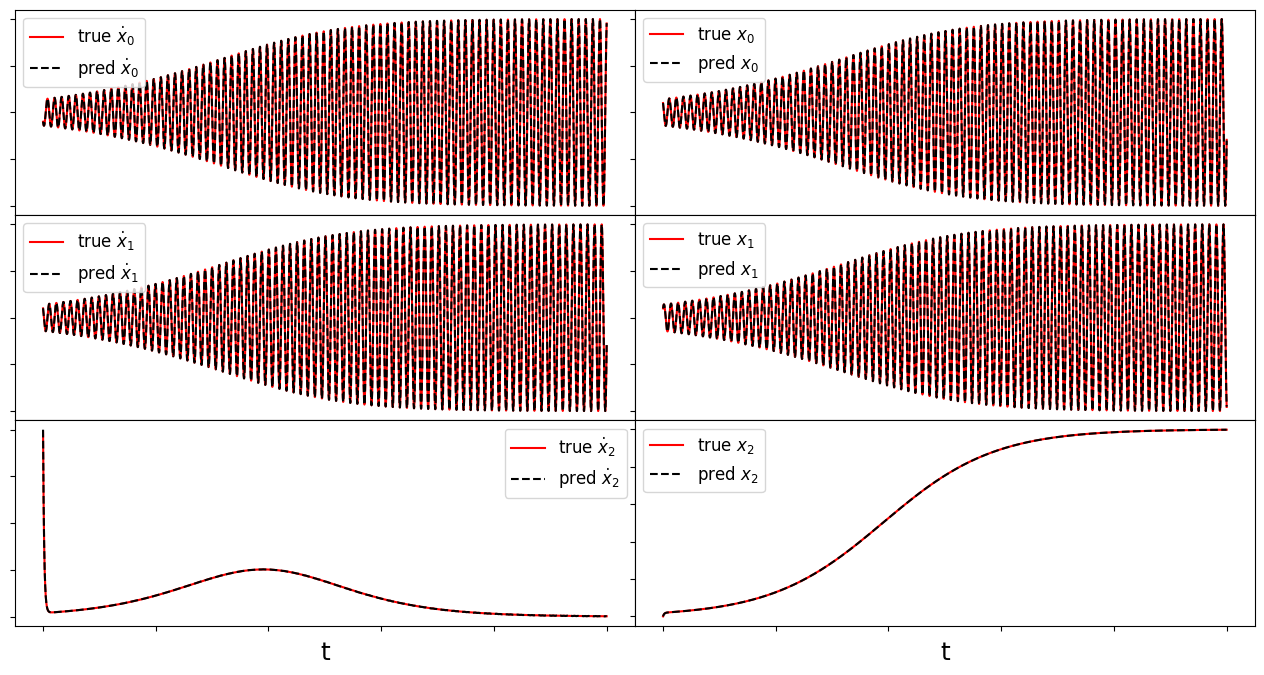

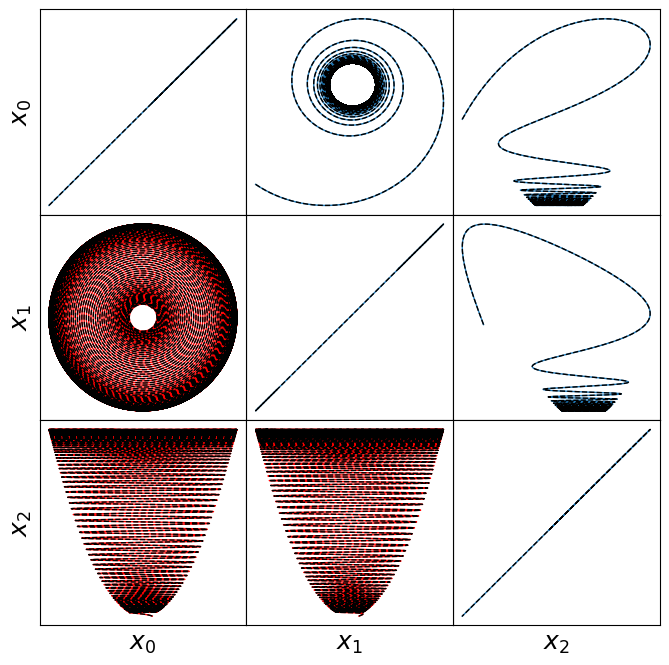

Frobenius Error =  0.005704957346431493
optimal m:  [-0.12526938 -0.0601213   1.31316903]
As eigvals:  [-1.31821899 -1.30305111 -0.9847679 ]
Estimate of trapping region size, Rm =  1.3340487988834187
Normalized trapping region size, Reff =  218.9318972285827
Frobenius coefficient error =  1.30927619535216
Time-averaged derivative error =  1.790109485624373e-11


In [3]:
# define parameters
r = 3
mu = 1e-2
dt = 0.01
T = 500
t = np.arange(0, T + dt, dt)
t_span = (t[0], t[-1])
x0 = np.random.rand(3) - 0.5
x_train = solve_ivp(meanfield, t_span, x0, t_eval=t, 
                    args=(mu,), **integrator_keywords).y.T
x0 = (mu, mu, 0)
x_test = solve_ivp(meanfield, t_span, x0, t_eval=t, 
                   args=(mu,), **integrator_keywords).y.T

# define hyperparameters
threshold = 0.0
eta = 1e5
max_iter = 5000

constraint_zeros, constraint_matrix = make_constraints(r)

# run trapping SINDy algorithm
sindy_opt = ps.TrappingSR3(threshold=threshold, eta=eta,
                           max_iter=max_iter, gamma=-1,
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature",
                           verbose=True
                           )

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t, quiet=True)
model.print()
Xi = model.coefficients().T
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

# plotting and analysis
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'meanfield')
make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, 'meanfield')
E_pred = np.linalg.norm(x_test - x_test_pred) / np.linalg.norm(x_test)
print('Frobenius Error = ', E_pred)
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, sindy_opt, mean_val)

# compute relative Frobenius error in the model coefficients
Xi_meanfield = np.zeros(Xi.shape)
Xi_meanfield[:r, :r] = np.asarray([[0.01, -1, 0], [1, 0.01, 0], [0, 0, -1]]).T
Xi_meanfield[r + 1, 0] = -1
Xi_meanfield[r + 2, 1] = -1
Xi_meanfield[r + 3, 2] = 1
Xi_meanfield[r + 4, 2] = 1
coef_pred = np.linalg.norm(Xi_meanfield - Xi) / np.linalg.norm(Xi_meanfield)
print('Frobenius coefficient error = ', coef_pred)

# Compute time-averaged dX/dt error
deriv_error = np.zeros(xdot_test.shape[0])
for i in range(xdot_test.shape[0]):
    deriv_error[i] = np.dot(xdot_test[i, :] - xdot_test_pred[i, :], 
                            xdot_test[i, :] - xdot_test_pred[i, :])  / np.dot(
                            xdot_test[i, :], xdot_test[i, :])
print('Time-averaged derivative error = ', np.nanmean(deriv_error))

Awesome! The trapping algorithm gets exactly the right model and produces a negative definite matrix,
$$\mathbf{A}^S = \begin{bmatrix}
    -1.32 & 0 & 0 \\
    0 & -1.31 & 0 \\
    0 & 0 & -1 
    \end{bmatrix},$$
i.e. it identifies $\epsilon \approx 1.3$ from above. Note that with different algorithm hyperparameters it will produce different $\epsilon$, since the algorithm only cares that the matrix is negative definite (i.e. only cares about the largest eigenvalue), not the precise value of $\epsilon$. Moreover, these eigenvalues can change as the algorithm converges further. 



# Atmospheric oscillator model
Here we briefly look at a more complicated Lorenz-like system of coupled oscillators that is motivated from atmospheric dynamics. The model is

$$
\begin{align}
\label{eq:oscillator}
    \frac{d}{dt}\begin{bmatrix}
    x \\ 
    y \\
    z \\
    \end{bmatrix} = \begin{bmatrix}
    \mu_1 & 0 & 0 \\
    0 & \mu_2 & \omega \\
    0 & -\omega & \mu_2 
    \end{bmatrix}\begin{bmatrix} 
    x \\ 
    y \\
    z 
    \end{bmatrix}
    +
    \begin{bmatrix}
    \sigma xy \\
    \kappa yz + \beta z^2 - \sigma x^2 \\
    - \kappa y^2 - \beta yz
    \end{bmatrix}.
\end{align}
$$

For comparison, we assume the parameter choices in Tuwankotta et al. (2006), $\mu_1 = 0.05$, $\mu_2 = -0.01$, $\omega = 3$, $\sigma = 1.1$, $\kappa = -2$, and $\beta = -6$, for which a limit cycle is known to exist. Again, the algorithm shows straightforward success finding a model with a trapping region, for a range of hyperparameter values.

(x0)' = 0.050 x0 + 1.100 x0x1
(x1)' = -0.010 x1 + 2.999 x2 + -1.998 x1x2 + -1.100 x0x0 + -4.998 x2x2
(x2)' = -2.999 x1 + -0.010 x2 + 4.998 x1x2 + 1.998 x1x1
Max deviation from the constraints =  1.7763568394002505e-15


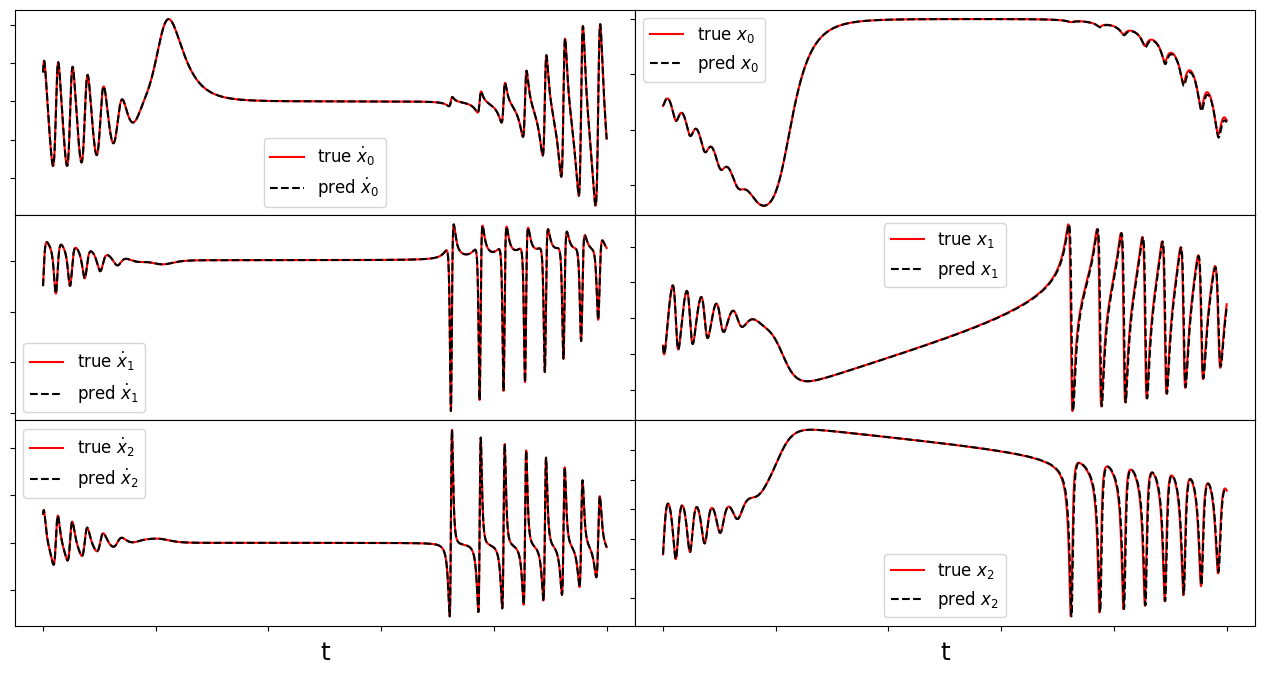

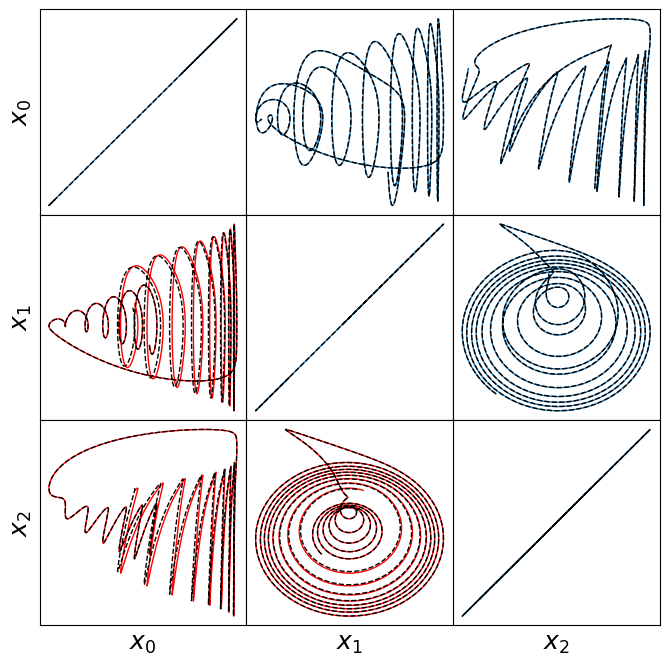

Frobenius error =  0.08563864373359147
optimal m:  [-0.18680949 -0.99662626  0.39835106]
As eigvals:  [-5.78728998e+00 -1.05469288e+00 -1.37058365e-03]
Estimate of trapping region size, Rm =  2343.1670471614552
Normalized trapping region size, Reff =  5099.062072563217
Frobenius coefficient error =  1.3939221822906473
Time-averaged derivative error =  4.1802065255271375e-06


In [4]:
# define parameters
r = 3
sigma = 1.1
beta = -5.0
eps = 0.01
k1 = 5
k2 = 1
mu1 = eps * k1
mu2 = -eps * k2
alpha = -2.0
omega = 3.0

# Make training and testing data
dt = 0.01
T = 100
t = np.arange(0, T + dt, dt)
t_span = (t[0], t[-1])
x0 = np.random.rand(3) - 0.5
x_train = solve_ivp(oscillator, t_span, x0, t_eval=t, 
                    args=(mu1, mu2, omega, alpha, beta, sigma), 
                    **integrator_keywords).y.T
x0 = np.random.rand(3) - 0.5
x_test = solve_ivp(oscillator, t_span, x0, t_eval=t,
                   args=(mu1, mu2, omega, alpha, beta, sigma), 
                   **integrator_keywords).y.T

# define hyperparameters
eta = 1.0e8

# run trapping SINDy, reusing previous threshold, max_iter and constraints
sindy_opt = ps.TrappingSR3(threshold=threshold, eta=eta, max_iter=max_iter,
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature",
                           )
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t, quiet=True)
model.print()
Xi = model.coefficients().T
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

PL_tensor = sindy_opt.PL_
PQ_tensor = sindy_opt.PQ_
L = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Q = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
Q_sum = np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1]))))
print('Max deviation from the constraints = ', Q_sum)

# plotting and analysis
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'oscillator')
make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, 'oscillator')
E_pred = np.linalg.norm(x_test - x_test_pred) / np.linalg.norm(x_test)
print('Frobenius error = ', E_pred)
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, sindy_opt, mean_val)

# compute relative Frobenius error in the model coefficients
Xi_oscillator = np.zeros(Xi.shape)
Xi_oscillator[:r, :r] = np.asarray([[0.05, 0, 0], 
                                    [0, -0.01, 3.0], 
                                    [0, -3.0, -0.01]]).T
Xi_oscillator[r, 0] = 1.1
Xi_oscillator[r + 2, 1] = -2
Xi_oscillator[r + 3, 1] = -1.1
Xi_oscillator[r + 5, 1] = -5
Xi_oscillator[r + 2, 2] = 5
Xi_oscillator[r + 4, 2] = 2
coef_pred = np.linalg.norm(Xi_oscillator - Xi) / np.linalg.norm(Xi_oscillator)
print('Frobenius coefficient error = ', coef_pred)

# Compute time-averaged dX/dt error
deriv_error = np.zeros(xdot_test.shape[0])
for i in range(xdot_test.shape[0]):
    deriv_error[i] = np.dot(xdot_test[i, :] - xdot_test_pred[i, :], 
                            xdot_test[i, :] - xdot_test_pred[i, :])  / np.dot(
                            xdot_test[i, :], xdot_test[i, :])
print('Time-averaged derivative error = ', np.nanmean(deriv_error))

optimal m:  [-0.18680949 -0.99662626  0.39835106]
As eigvals:  [-5.78728998e+00 -1.05469288e+00 -1.37058365e-03]


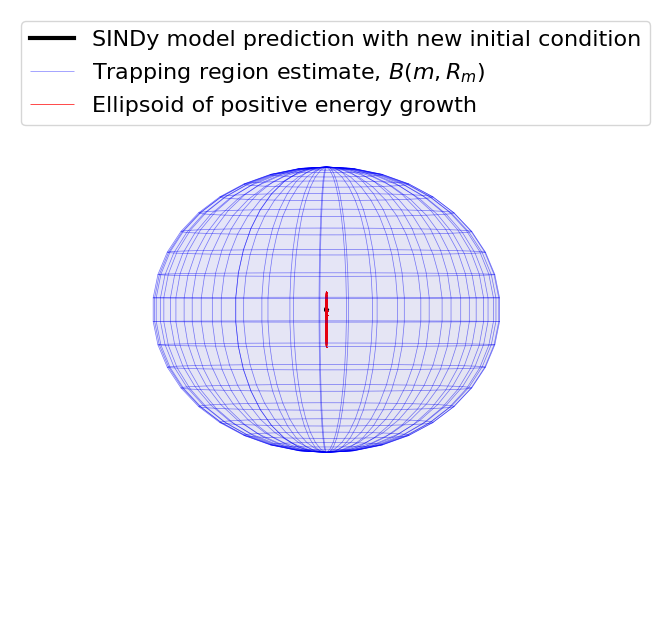

In [5]:
# make 3D illustration of the trapping region
trapping_region(r, x_test_pred, Xi, sindy_opt, 'Atmospheric Oscillator')


### We identified a very accurate and provably stable model but the trapping region looks way too big... what's going on here?
The estimate for the size of the trapping region is based on the smallest eigenvalue of $\mathbf{A}^S$. But this system has a big scale-separation, leading to $\lambda_1 = -0.01$ (while $\lambda_3 = -5.4$) and an estimate of the trapping region of $R_m = d/\lambda_1 \approx 300$. This is because our estimate of the trapping region comes from the worst case scenario.  

# Lorenz model
The Lorenz system originates from a simple fluid model of atmospheric dynamics from Lorenz et al. (1963).
This system is likely the most famous example of chaotic, nonlinear behavior despite the somewhat innocuous system of equations,

$$
\begin{align}
    \frac{d}{dt}\begin{bmatrix}
    x \\ 
    y \\
    z \\
    \end{bmatrix} &= \begin{bmatrix}
    -\sigma & \sigma & 0 \\
    \rho & -1 & 0 \\
    0 & 0 & -\beta
    \end{bmatrix}
    \begin{bmatrix}
    x \\
    y \\
    z
    \end{bmatrix}
    +
    \begin{bmatrix}
    0 \\
    -xz \\
    xy
    \end{bmatrix}, \qquad
    \mathbf{A}^S = \begin{bmatrix}
    -\sigma & \frac{1}{2}(\rho+\sigma - m_3) & \frac{1}{2}m_2 \\
    \frac{1}{2}(\rho+\sigma - m_3) & -1 & 0 \\
    \frac{1}{2}m_2 & 0 & -\beta 
    \end{bmatrix}.
\end{align}
$$

For Lorenz's choice of parameters, $\sigma = 10$, $\rho = 28$, $\beta  = 8/3$, this system is known to exhibit a stable attractor. For $\mathbf{m} = [0,m_2,\rho+\sigma]$ ($m_1$ does not contribute to $\mathbf{A}^S$ so we set it to zero),

$$
\begin{align}
    \mathbf{A}^S &= \begin{bmatrix}
    -\sigma & 0 & \frac{1}{2}m_2 \\
    0 & -1 & 0 \\
    \frac{1}{2}m_2 & 0 & -\beta 
    \end{bmatrix}, \qquad
    \lambda_1 = -1, \qquad \lambda_{\pm} = -\frac{1}{2}\left[\beta+\sigma \mp \sqrt{m_2^2 + (\beta-\sigma)^2}\right],
\end{align}
$$

so that if $\lambda_{\pm} < 0$, then $-2\sqrt{\sigma\beta} < m_2 < 2\sqrt{\sigma\beta}$. 
Our algorithm can successfully identify the optimal $\mathbf{m}$, and can be used to identify the inequality bounds on $m_2$ for stability. 

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 2.467e+02 ... 1.273e-01 ... 0.00e+00 ... 4.93e-21 ... 2.43e-47 ... 2.47e+02
  500 ... 2.467e+02 ... 2.368e-06 ... 0.00e+00 ... 4.93e-21 ... 4.51e-47 ... 2.47e+02
 1000 ... 2.467e+02 ... 7.504e-07 ... 0.00e+00 ... 4.93e-21 ... 7.81e-48 ... 2.47e+02
 1500 ... 2.467e+02 ... 4.350e-07 ... 0.00e+00 ... 4.93e-21 ... 1.15e-46 ... 2.47e+02
 2000 ... 2.467e+02 ... 3.175e-07 ... 0.00e+00 ... 4.93e-21 ... 3.57e-47 ... 2.47e+02
 2500 ... 2.467e+02 ... 2.605e-07 ... 0.00e+00 ... 4.93e-21 ... 3.12e-47 ... 2.47e+02
 3000 ... 2.467e+02 ... 2.288e-07 ... 0.00e+00 ... 4.93e-21 ... 5.05e-47 ... 2.47e+02
 3500 ... 2.467e+02 ... 2.095e-07 ... 0.00e+00 ... 4.93e-21 ... 9.45e-47 ... 2.47e+02
 4000 ... 2.467e+02 ... 1.972e-07 ... 0.00e+00 ... 4.93e-21 ... 1.92e-47 ... 2.47e+02
 4500 ... 2.467e+02 ... 1.891e-07 ... 0.00e+00 ... 4.93e-21 ... 3.57e-47 ... 2.47e+02
(x0)' = 0.085 1 + -9.858 x0 + 9.933 x1 + -0.012 x2 

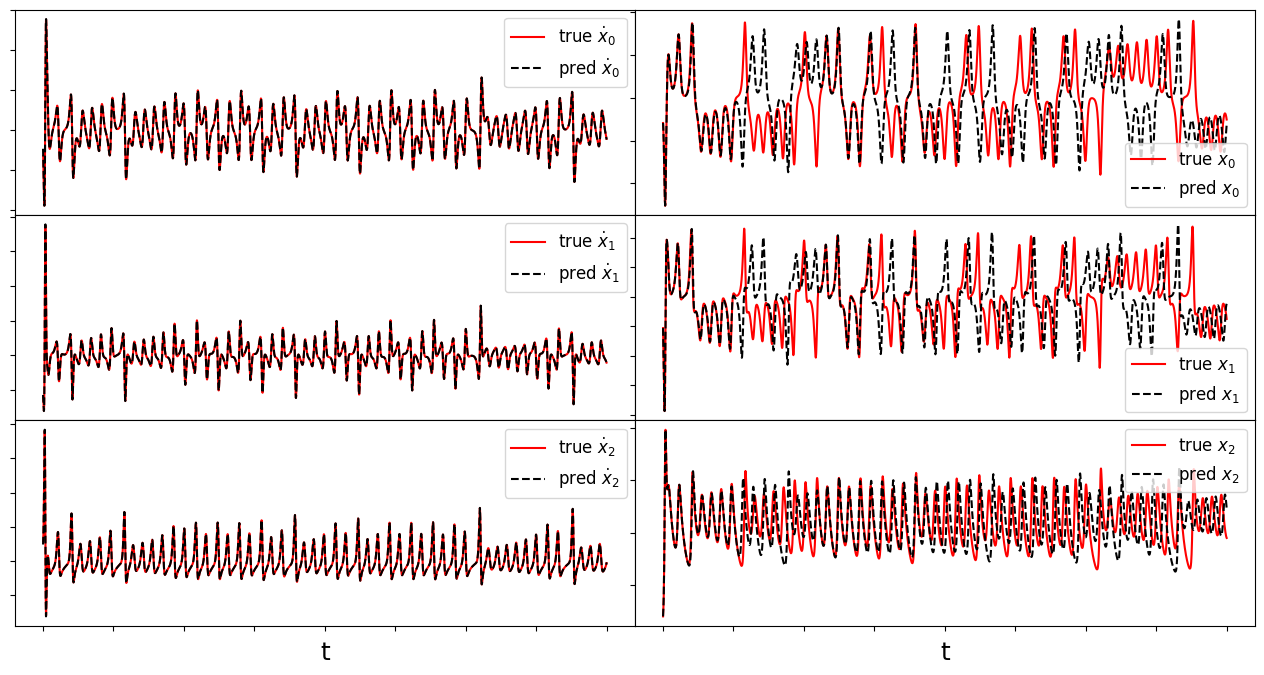

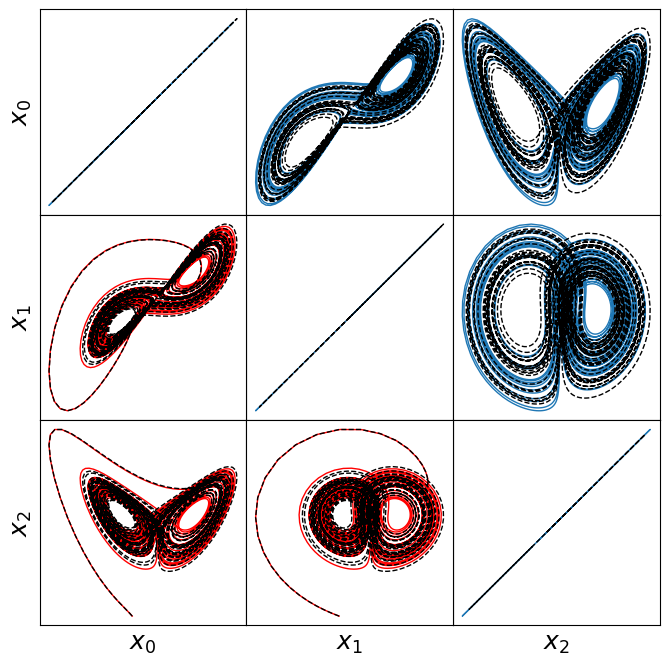

Max deviation from the constraints =  3.178967505901298e-14
optimal m:  [-1.09252491 -0.11882176 37.85654195]
As eigvals:  [-9.97204347 -2.66374066 -0.98084075]
Estimate of trapping region size, Rm =  103.66483687305976
Normalized trapping region size, Reff =  4.396370800957477
Frobenius error =  0.6452799501348792
Frobenius coefficient error =  1.5027993206113361
Time-averaged derivative error =  1.527253106087817e-05


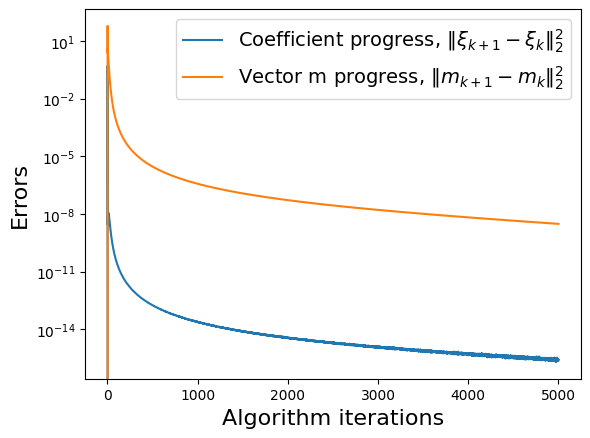

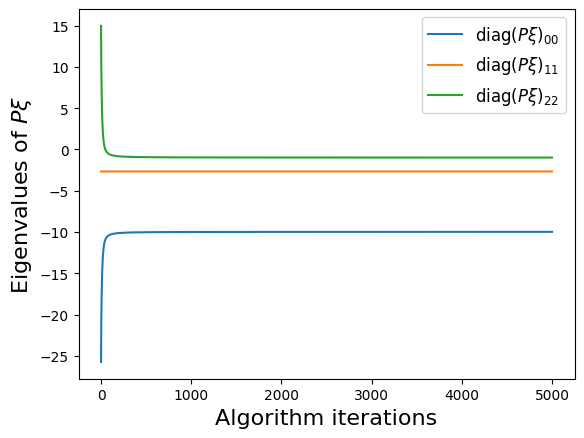

In [6]:
# define parameters
r = 3

# make training and testing data
dt = 0.01
T = 40
t = np.arange(0, T + dt, dt)
t_span = (t[0], t[-1])
x0 = [1, -1, 20]
x_train = solve_ivp(lorenz, t_span, x0, t_eval=t, **integrator_keywords).y.T
x0 = (np.random.rand(3) - 0.5) * 30
x_test = solve_ivp(lorenz, t_span, x0, t_eval=t, **integrator_keywords).y.T

# define hyperparameters
threshold = 0
max_iter = 5000
eta = 1.0e3

alpha_m = 8e-1 * eta  # default is 1e-2 * eta so this speeds up the code here
accel = True  # use acceleration for the update of (m, A), sometimes is faster

# run trapping SINDy
sindy_opt = ps.TrappingSR3(threshold=threshold, eta=eta, alpha_m=alpha_m,
                           accel=accel, max_iter=max_iter, gamma=-1,
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature",
                           verbose=True
                           )
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t, quiet=True)
model.print()

Xi = model.coefficients().T
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

# plotting and analysis
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'lorenz')
make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, 'lorenz')
make_progress_plots(r, sindy_opt)

PL_tensor = sindy_opt.PL_
PQ_tensor = sindy_opt.PQ_
L = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Q = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
Q_sum = np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1]))))
print('Max deviation from the constraints = ', Q_sum)

mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, sindy_opt, mean_val)
E_pred = np.linalg.norm(x_test - x_test_pred) / np.linalg.norm(x_test)
print('Frobenius error = ', E_pred)

# compute relative Frobenius error in the model coefficients
sigma = 10
rho = 28
beta = 8.0 / 3.0
Xi_lorenz = np.zeros(Xi.shape)
Xi_lorenz[:r, :r] = np.asarray([[-sigma, sigma, 0], [rho, -1, 0], [0, 0, -beta]]).T
Xi_lorenz[r + 1, 1] = -1
Xi_lorenz[r, 2] = 1
coef_pred = np.linalg.norm(Xi_lorenz - Xi) / np.linalg.norm(Xi_lorenz)
print('Frobenius coefficient error = ', coef_pred)

# Compute time-averaged dX/dt error
deriv_error = np.zeros(xdot_test.shape[0])
for i in range(xdot_test.shape[0]):
    deriv_error[i] = np.dot(xdot_test[i, :] - xdot_test_pred[i, :], 
                            xdot_test[i, :] - xdot_test_pred[i, :])  / np.dot(
                            xdot_test[i, :], xdot_test[i, :])
print('Time-averaged derivative error = ', np.nanmean(deriv_error))

# Visualizing the trapping region for Lorenz
Below, we plot the SINDy-identified trapping region (red) and the analytic trapping region (cyan) for the Lorenz system. The estimate for the trapping region (blue) correctly encloses the Lorenz attractor, and the red ellipsoid of positive energy growth. We can see that trajectories starting outside of this region monotonically fall into this region and remain forever, and the red and cyan ellipsoids agree well.

optimal m:  [-1.09252491 -0.11882176 37.85654195]
As eigvals:  [-9.97204347 -2.66374066 -0.98084075]


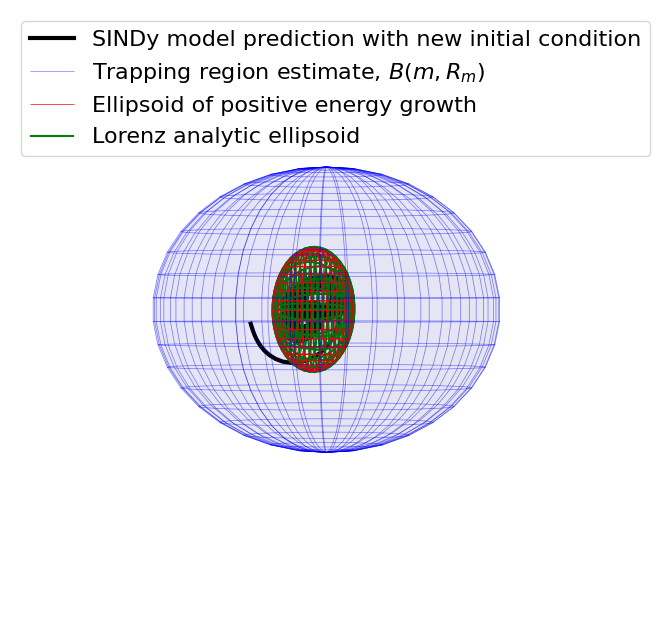

In [7]:
# make 3D illustration of the trapping region
trapping_region(r, x_test_pred, Xi, sindy_opt, 'Lorenz Attractor')

### Some of these plots are different looking than in the Trapping SINDy paper
This is because (1) there were a few small errors in the original code and (2) we are now plotting the trapping regions not in the $\mathbf{a}(t)$ or $\mathbf{y}(t) = \mathbf{a}(t) - \mathbf{m}$ spaces, but instead in the $\mathbf{z}(t)$ eigenvector coordinates of $\mathbf{A}^S$, where the definition of the ellipsoid makes the most sense, and (3) the paper examples are typically generated from fully converged solutions run for many additional iterations. See the paper for a review of this notation.

# MHD model
Magnetohydrodynamics exhibit quadratic nonlinearities that are often energy-preserving with typical boundary conditions. 
We consider a simple model of the nonlinearity in 2D incompressible MHD, which can be obtained from Fourier-Galerkin projection onto a single triad of wave vectors. For the wave vectors $(1,1)$, $(2,-1)$, and $(3,0)$ and no background magnetic field, the Carbone and Veltri (1992) system is 

$$
\begin{align}
\label{eq:simpleMHD_model}
    \begin{bmatrix}
    \dot{V}_1 \\
    \dot{V}_2 \\
    \dot{V}_3 \\ 
    \dot{B}_1 \\
    \dot{B}_2 \\
    \dot{B}_3 \\
    \end{bmatrix} = \begin{bmatrix}
    -2 \nu & 0 & 0 & 0 & 0 & 0 \\
    0 & -5 \nu & 0 & 0 & 0 & 0 \\
    0 & 0 & -9 \nu & 0 & 0 & 0 \\
    0 & 0 & 0 & -2 \mu & 0 & 0 \\
    0 & 0 & 0 & 0 & -5 \mu & 0 \\
    0 & 0 & 0 & 0 & 0 & -9 \mu \\
    \end{bmatrix}\begin{bmatrix}
    V_1 \\ 
    V_2 \\ 
    V_3 \\ 
    B_1 \\ 
    B_2 \\ 
    B_3 
    \end{bmatrix} + \begin{bmatrix}
    4(V_2V_3 - B_2B_3) \\ 
    -7(V_1V_3 - B_1B_3) \\ 
    3(V_1V_2 - B_1B_2) \\ 
    2(B_3V_2 - V_3B_2) \\ 
    5(V_3B_1 - B_3V_1) \\ 
    9(V_1B_2 - B_1V_2) \\ 
    \end{bmatrix},
\end{align}
$$

where $\nu \geq 0$ is the viscosity and $\mu \geq 0$ is the resistivity. Without external forcing, this system is trivially stable (it dissipates to zero), so we consider the inviscid limit $\nu = \mu = 0$. The system is then Hamiltonian and our algorithm correctly converges to $\mathbf{m} = 0$, $\mathbf{A}^S = 0$. The reason our algorithm converges to the correct behavior is because it is still minimizing $\dot{K}$; in this case trapping SINDy minimizes to $\dot{K} \approx 0$ and can make no further improvement.

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 2.202e-04 ... 1.071e-08 ... 0.00e+00 ... 9.18e-19 ... 1.28e-27 ... 2.20e-04
  100 ... 2.209e-04 ... 4.172e-11 ... 0.00e+00 ... 9.18e-19 ... 1.93e-28 ... 2.21e-04
  200 ... 2.203e-04 ... 5.567e-12 ... 0.00e+00 ... 9.18e-19 ... 3.66e-28 ... 2.20e-04
  300 ... 2.204e-04 ... 3.047e-12 ... 0.00e+00 ... 9.18e-19 ... 3.65e-28 ... 2.20e-04
  400 ... 2.206e-04 ... 3.002e-12 ... 0.00e+00 ... 9.18e-19 ... 3.45e-28 ... 2.21e-04
  500 ... 2.204e-04 ... 3.001e-12 ... 0.00e+00 ... 9.18e-19 ... 1.91e-28 ... 2.20e-04
  600 ... 2.211e-04 ... 3.001e-12 ... 0.00e+00 ... 9.18e-19 ... 3.56e-28 ... 2.21e-04
  700 ... 2.203e-04 ... 3.001e-12 ... 0.00e+00 ... 9.18e-19 ... 7.09e-28 ... 2.20e-04
  800 ... 2.211e-04 ... 3.001e-12 ... 0.00e+00 ... 9.18e-19 ... 6.22e-28 ... 2.21e-04
  900 ... 2.204e-04 ... 3.001e-12 ... 0.00e+00 ... 9.18e-19 ... 4.05e-28 ... 2.20e-04
(x0)' = 3.996 x1x2 + 0.004 x1x5 + 0.002 x2x4 + -4.0

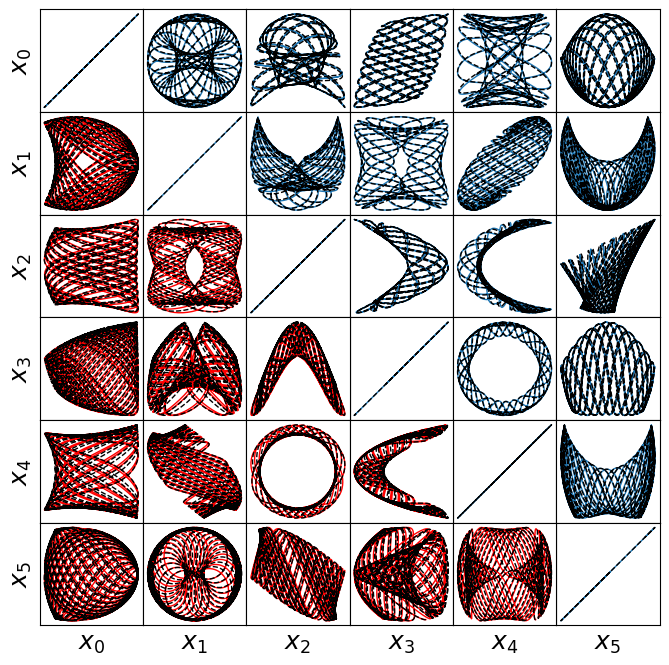

optimal m:  [-5.67385639e-06 -2.32845064e-06  2.52558822e-04  5.57905844e-07
 -1.93716926e-06  9.54880176e-05]
As eigvals:  [-1.08517009e-03 -4.09388159e-05  2.81239406e-06  2.02752548e-05
  6.42456086e-05  1.11653987e-03]
Estimate of trapping region size, Rm =  0.04805627673558245
Normalized trapping region size, Reff =  0.13601774395279312
0.10545867108512927
(x0)' = 4.00 x1x2 + -4.00 x4x5
(x1)' = -6.99 x0x2 + 6.99 x3x5
(x2)' = 2.99 x0x1 + -3.00 x3x4
(x3)' = 2.00 x1x5 + -2.00 x2x4
(x4)' = -4.99 x0x5 + 5.00 x2x3
(x5)' = 8.99 x0x4 + -8.99 x1x3
Time-averaged derivative error =  1.2056776588284959e-06


In [8]:
# define parameters
r = 6
nu = 0.0  # viscosity
mu = 0.0  # resistivity

# define training and testing data
dt = 0.02
T = 50
t = np.arange(0, T + dt, dt)
t_span = (t[0], t[-1])
x0 = (np.random.rand(6) - 0.5)
x_train = solve_ivp(mhd, t_span, x0, t_eval=t, **integrator_keywords).y.T
x0 = (np.random.rand(6) - 0.5)
x_test = solve_ivp(mhd, t_span, x0, t_eval=t, **integrator_keywords).y.T

# define hyperparameters
threshold = 0.0
max_iter = 1000
eta = 1.0e10
alpha_m = 5.0e-1 * eta
    
constraint_zeros, constraint_matrix = make_constraints(r)

# run trapping SINDy with "relax_optim = False" here, uses CVXPY now 
# so this tends to be much slower but often need far fewer algorithm iterations.
# For this problem, a single (very slow) update is all that is needed!
sindy_opt = ps.TrappingSR3(threshold=threshold, eta=eta,
                           max_iter=max_iter,
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature",
                           verbose=True)
                           # eps_solver=1e-3)  # reduce the solver tolerance for speed
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t, quiet=True)
model.print()
Xi = model.coefficients().T
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

PL_tensor = sindy_opt.PL_
PQ_tensor = sindy_opt.PQ_
L = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Q = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
Q_sum = np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1]))))
print('Max deviation from the constraints = ', Q_sum)

# plotting and analysis
make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, 'mhd')
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, sindy_opt, mean_val)
E_pred = np.linalg.norm(x_test - x_test_pred) / np.linalg.norm(x_test)
print(E_pred)

# compute relative Frobenius error in the model coefficients
Xi_mhd = np.zeros(Xi.shape)
Xi_mhd[r + 5, 0] = 4.0
Xi_mhd[r + 14, 0] = -4.0
Xi_mhd[r + 1, 1] = -7
Xi_mhd[r + 13, 1] = 7.0
Xi_mhd[r, 2] = 3.0
Xi_mhd[r + 12, 2] = -3.0
Xi_mhd[r + 8, 3] = 2.0
Xi_mhd[r + 10, 3] = -2.0
Xi_mhd[r + 4, 4] = -5.0
Xi_mhd[r + 9, 4] = 5.0
Xi_mhd[r + 3, 5] = 9.0
Xi_mhd[r + 6, 5] = -9.0
model.print(precision=2)
coef_pred = np.linalg.norm(Xi_mhd - Xi) / np.linalg.norm(Xi_mhd)

# Compute time-averaged dX/dt error
deriv_error = np.zeros(xdot_test.shape[0])
for i in range(xdot_test.shape[0]):
    deriv_error[i] = np.dot(xdot_test[i, :] - xdot_test_pred[i, :], 
                            xdot_test[i, :] - xdot_test_pred[i, :])  / np.dot(
                            xdot_test[i, :], xdot_test[i, :])
print('Time-averaged derivative error = ', np.nanmean(deriv_error))

# Forced Burger's Equation
The viscous Burgers' equation has long served as a simplified one-dimensional turbulence analogue (Burgers/Hopf 1948). The forced, viscous Burgers' equation on a periodic domain $x \in [0,2\pi)$ is:

$$
\begin{align}
\label{eq:burgers}
    \dot{u} &= -(U + u)\partial_x u + \nu \partial_{xx}^2u + g(x,t),
\end{align}
$$

where $\nu$ is viscosity and the constant $U$ models mean-flow advection. 
We project this system onto a Fourier basis and assume constant forcing acting on the largest scale, i.e. $g(x, t) = \sigma \left( a_1(t) e^{ix} + a_{-1}(t) e^{-ix} \right)$ as in Noack and Schlegel et al. (2008).
After Fourier projection, the evolution of the coefficients $a_k(t)$ is given by the Galerkin dynamics

$$
\begin{equation}
\label{eq:burgers_galerkin}
    \dot{a}_k = \left( \delta_{|k|1} \sigma - \nu k^2  - ikU \right) a_k - \sum_{\ell=-r}^{r} i \ell a_{\ell} a_{k - \ell}.
\end{equation}
$$

In the subcritical case $\sigma < \nu$ the origin of this system is stable to all perturbations and all solutions decay on long times.
However, in the supercritical case $\sigma > \nu$ the excess energy input from the forcing cascades to the smaller dissipative scales. 
The absolute equilibrium limit $\sigma = \nu = 0$ has a Hamiltonian structure; at long times the coefficients approach thermodynamic equilibrium and equipartition of energy. For the supercritical condition $\sigma > \nu$, the trapping SINDy algorithm does not converge to a negative definite $\mathbf{A}^S$ because this system does not exhibit effective nonlinearity. 

We do not make a trapping SINDy model here because it takes a while to run. Instead, we show below that it does not fit the criteria of being effectively nonlinear.

In [9]:
# define parameters and load in training DNS data
tstart = 0
tend = 3000
Burgers = sio.loadmat('../data/burgers_highres2.mat')
skip = 1
nu = Burgers['nu'].item()
sigma = Burgers['sigma'].item()
U = Burgers['U'].item()
t = (Burgers['t'].flatten())[tstart:tend:skip]
x_train = Burgers['a']
u_train = Burgers['u'][:, tstart:tend:skip]
theta = Burgers['x'].flatten()
spatial_modes_train = Burgers['theta']
r = 10
x_train = x_train[:r, tstart:tend:skip].T

### Forced Burgers' system is not effectively nonlinear
The last bit of information we will get from this system is checking if the analytic model exhibits effective nonlinearity, a requirement for the Schlegel and Noack trapping theorem to hold. 

Using a simulated annealing algorithm, we can show that even the analytic 10D Galerkin Noack and Schlegel et al. (2008) model does not exhibit a $\mathbf{m}$ such that $\mathbf{A}$^S is negative definite. This is because the nonlinearity is not 'effective'. 

In [10]:
from scipy.optimize import dual_annealing as anneal_algo

# get analytic L and Q operators and galerkin model
L, Q = burgers_galerkin(sigma, nu, U)
rhs = lambda t, a : galerkin_model(a, L, Q)

# Generate initial condition from unstable eigenvectors
lamb, Phi = np.linalg.eig(L)
idx = np.argsort(-np.real(lamb))
lamb, Phi = lamb[idx], Phi[:, idx]
a0 = np.real( 1e-4 * Phi[:, :2] @ np.random.random((2)) )

# define parameters
dt = 1e-3
r = 10
t_sim = np.arange(0, 300, dt)
t_span = (t_sim[0], t_sim[-1])
x_train = solve_ivp(rhs, t_span, a0, t_eval=t_sim, **integrator_keywords).y.T

# Search between -500, 500 for each component of m
boundvals = np.zeros((r, 2))
boundmax = 500
boundmin = -500
boundvals[:, 0] = boundmin
boundvals[:, 1] = boundmax

# run simulated annealing and display optimal m and 
# the corresponding objective function value
Ls = 0.5 * (L + L.T)

# obj_function defined in the utils python file
algo_sol = anneal_algo(obj_function, bounds=boundvals, args=(Ls, Q, np.eye(r)), maxiter=2000)
opt_m = algo_sol.x
opt_energy = algo_sol.fun
opt_result = algo_sol.message
print('Simulated annealing ended because ' + opt_result[0])
print('Optimal m = ', opt_m)
print('Algorithm managed to reduce the largest eigenvalue of A^S to eig1 = ', 
      opt_energy)
print('Since the largest eigenvalue cannot be made negative, '
      'we conclude that effective nonlinearity does not hold for this system.')

Simulated annealing ended because Maximum number of iteration reached
Optimal m =  [-7.12302382e-04 -4.40284055e-03 -1.58299015e-05  1.08138440e-05
 -4.91821468e-04 -4.80252761e-04 -3.20141442e-04  4.58715217e-04
 -6.53605444e-04 -2.05329274e-04]
Algorithm managed to reduce the largest eigenvalue of A^S to eig1 =  0.07501557593796108
Since the largest eigenvalue cannot be made negative, we conclude that effective nonlinearity does not hold for this system.


# Von Karman shedding behind circular cylinder, Re = 100
In many cases, the wake behind a bluff body is characterized by a periodic vortex shedding phenomenon known as a von Karman street.
The two-dimensional incompressible flow past a cylinder is a stereotypical example of such behavior.

The transient energy growth and saturation amplitude of this instability mode is of particular interest and has historically posed a significant modeling challenge.
Noack et al. (2003) used an 8-mode POD basis that was augmented with a ninth "shift mode" parameterizing a mean flow deformation. The 9-mode quadratic Galerkin model does resolve the transient dynamics, nonlinear stability mechanism, and post-transient oscillation, accurately reproducing all of the key physical features of the vortex street. Moreover, in Schlegel and Noack (2015) stability of the quadratic model was proven with $m_9 = m_\text{shift} = \epsilon$, $\epsilon > 1$, and $m_i = 0$ for $i = \{1,...,8\}$. Note that POD-Galerkin models will generally weakly satisfy the effective nonlinearity criteria, although the addition of the shift-mode is a complication.

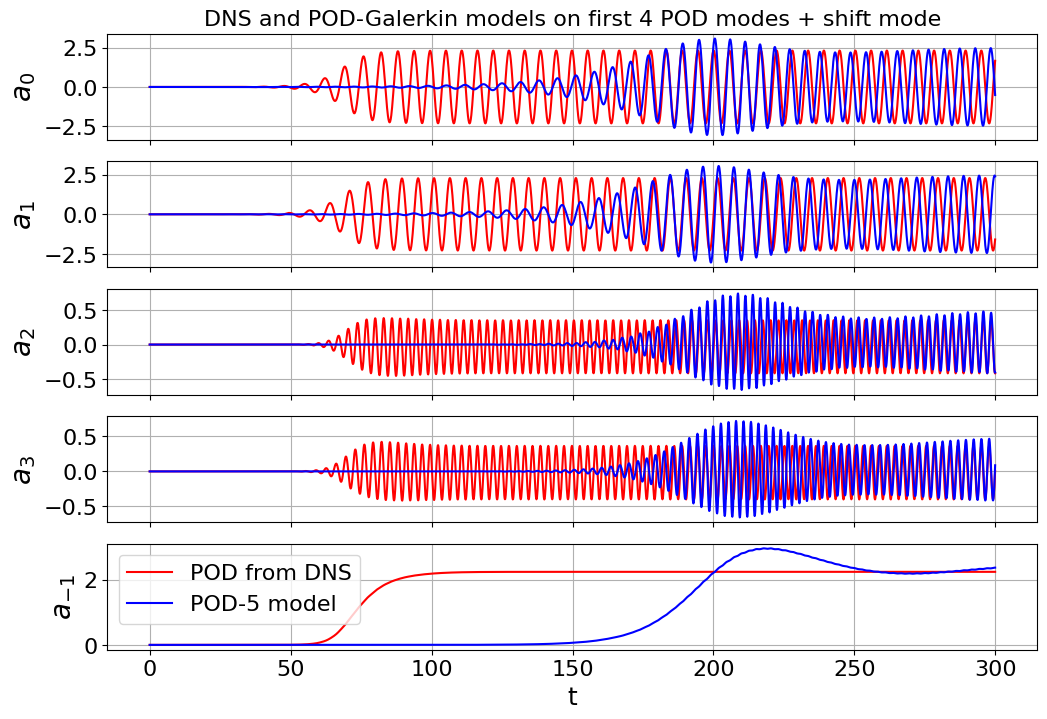

In [11]:
# define parameters and load in POD modes obtained from DNS
a = np.loadtxt('../data/vonKarman_pod/vonKarman_a.dat')
t = a[:, 0]
r = 5
a_temp = a[:, 1:r]
a_temp = np.hstack((a_temp, a[:, -1].reshape(3000, 1)))
a = a_temp
tbegin = 0
tend = 3000
skip = 1
t = t[tbegin:tend:skip]
a = a[tbegin:tend:skip, :]
dt = t[1] - t[0]

# define the POD-Galerkin models from Noack (2003)
galerkin9 = sio.loadmat('../data/vonKarman_pod/galerkin9.mat')

# make the Galerkin model nonlinearity exactly energy-preserving 
# rather than just approximately energy-preserving
gQ = 0.5 * (galerkin9['Q'] + np.transpose(galerkin9['Q'], [0, 2, 1]))
galerkin9['Q'] = gQ - (gQ + np.transpose(gQ, [1, 0, 2]) + np.transpose(
    gQ, [2, 1, 0]) + np.transpose(
    gQ, [0, 2, 1]) + np.transpose(
    gQ, [2, 0, 1]) + np.transpose(
    gQ, [1, 2, 0])) / 6.0

# time base for simulating Galerkin models
t_sim = np.arange(0, 500, dt)

# Generate initial condition from unstable eigenvectors
lamb, Phi = np.linalg.eig(galerkin9['L'])
idx = np.argsort(-np.real(lamb))
lamb, Phi = lamb[idx], Phi[:, idx]
a0 = np.zeros(9)
a0[0] = 1e-3
# np.real( 1e-3 * Phi[:, :2] @ np.random.random((2)) )

# get the 5D POD-Galerkin coefficients
inds5 = np.ix_([0, 1, 2, 3, -1], [0, 1, 2, 3, -1])
galerkin5 = {}
galerkin5['L'] = galerkin9['L'][inds5]
inds5 = np.ix_([0, 1, 2, 3, -1], [0, 1, 2, 3, -1], [0, 1, 2, 3, -1])
galerkin5['Q'] = galerkin9['Q'][inds5]
model5 = lambda t, a: galerkin_model(a, galerkin5['L'], galerkin5['Q'])

# make the 3D, 5D, and 9D POD-Galerkin trajectories
t_span = (t[0], t[-1])
a_galerkin5 = solve_ivp(model5, t_span, a0[:5], t_eval=t, 
                        **integrator_keywords).y.T
adot_galerkin5 = np.gradient(a_galerkin5, axis=0) / (t[1] - t[0])

# plot the first 4 POD modes + the shift mode
mode_numbers = [0, 1, 2, 3, -1]
plt.figure(figsize=(12, 8))
for i in range(r):
    plt.subplot(r, 1, i + 1)
    if i == 0:
        plt.title('DNS and POD-Galerkin models on first 4 POD modes + shift mode', 
                  fontsize=16)
    plt.plot(t, a[:, mode_numbers[i]], 'r', label='POD from DNS')
    plt.plot(t, a_galerkin5[:, mode_numbers[i]], 'b', label='POD-5 model')
    ax = plt.gca()
    plt.ylabel(r'$a_{' + str(mode_numbers[i]) + '}$', fontsize=20)
    plt.grid(True)
    if i == r - 1:
        plt.xlabel('t', fontsize=18)
        plt.legend(loc='upper left', fontsize=16)
    else:
        ax.set_xticklabels([])
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
a0 = np.zeros(r)
a0[0] = 1e-3

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 8.602e-01 ... 2.861e-03 ... 0.00e+00 ... 6.73e-22 ... 1.60e-44 ... 8.63e-01
  500 ... 8.645e-01 ... 1.440e-05 ... 0.00e+00 ... 7.70e-22 ... 1.85e-41 ... 8.65e-01
 1000 ... 8.741e-01 ... 1.304e-06 ... 0.00e+00 ... 9.31e-22 ... 9.76e-42 ... 8.74e-01
 1500 ... 8.773e-01 ... 2.844e-07 ... 0.00e+00 ... 9.78e-22 ... 6.12e-42 ... 8.77e-01
 2000 ... 8.787e-01 ... 7.090e-08 ... 0.00e+00 ... 9.97e-22 ... 5.59e-42 ... 8.79e-01
 2500 ... 8.793e-01 ... 1.858e-08 ... 0.00e+00 ... 1.01e-21 ... 5.20e-42 ... 8.79e-01
 3000 ... 8.796e-01 ... 4.984e-09 ... 0.00e+00 ... 1.01e-21 ... 4.93e-42 ... 8.80e-01
 3500 ... 8.798e-01 ... 1.352e-09 ... 0.00e+00 ... 1.01e-21 ... 6.30e-42 ... 8.80e-01
Max deviation from the constraints =  1.0913936421275139e-11


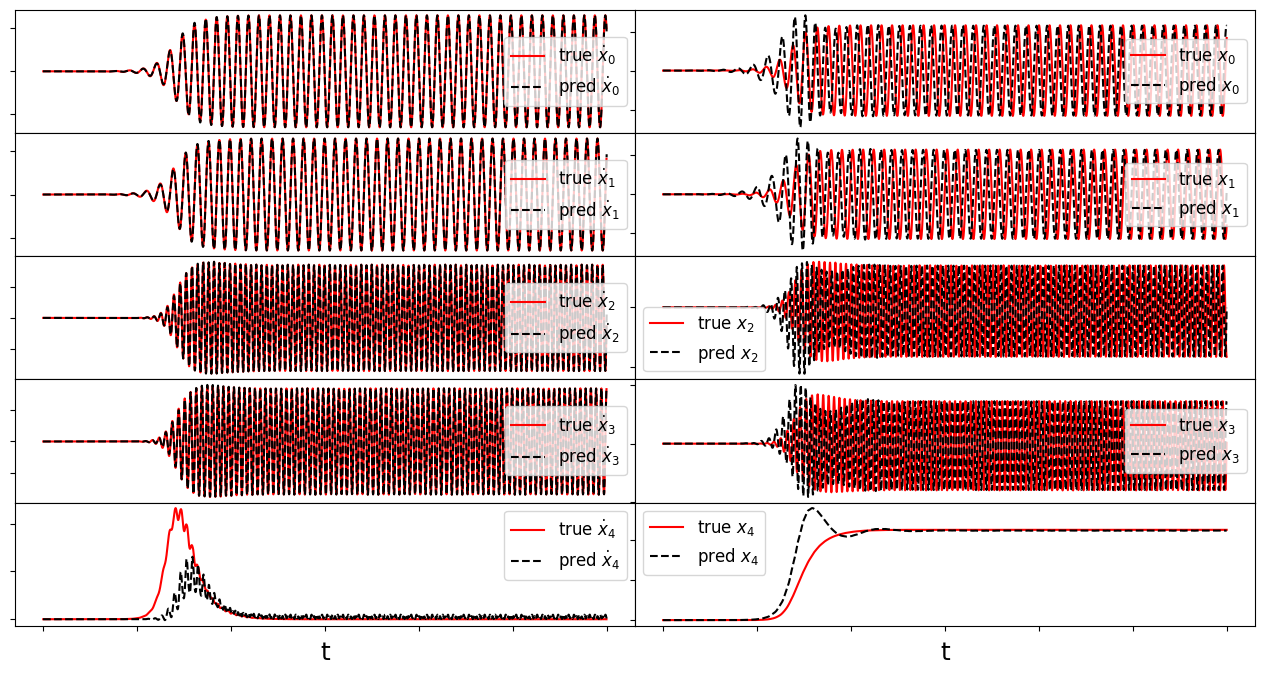

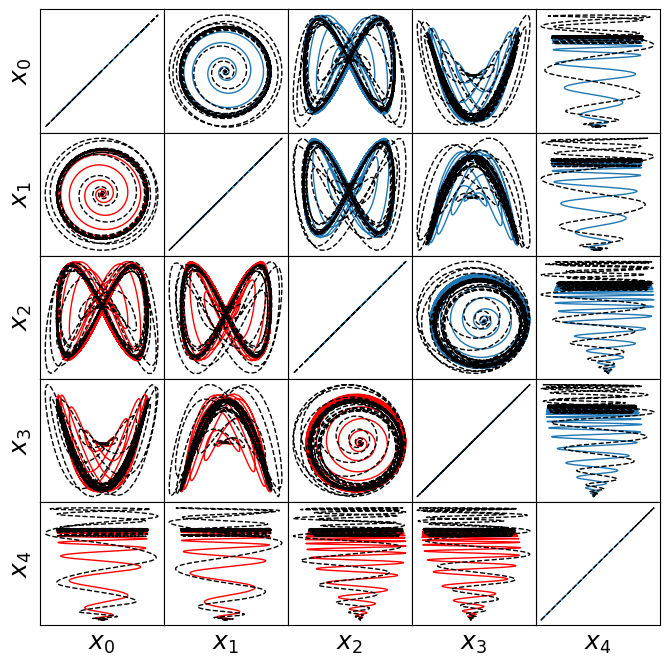

optimal m:  [-0.05832118  0.03872255 -0.42124785 -0.67206287  4.13206187]
As eigvals:  [-0.39366177 -0.27026714 -0.18709103 -0.0998585  -0.09970648]
Estimate of trapping region size, Rm =  20.06264553129367
Normalized trapping region size, Reff =  11.496778762185722
Frobenius Error =  1.0015055046161452
Time-averaged derivative error =  0.0024199584579544767


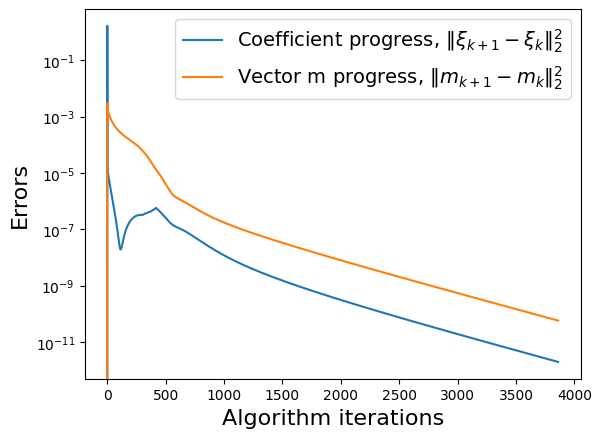

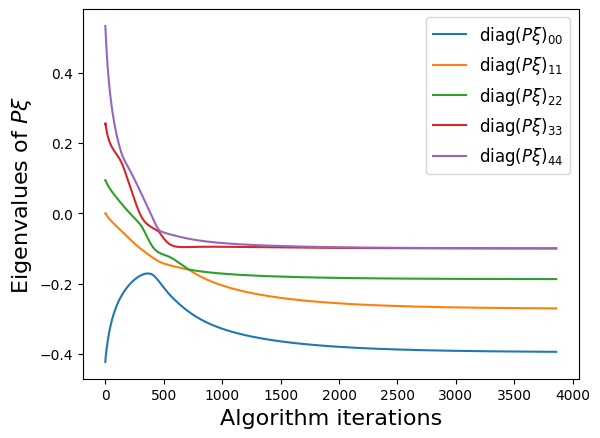

In [12]:
# same test and train trajectory for simplicity here
a = np.loadtxt('../data/vonKarman_pod/vonKarman_a.dat')
t = a[:, 0]
r = 5
a_temp = a[:, 1:r]
a_temp = np.hstack((a_temp, a[:, -1].reshape(3000, 1)))
a = a_temp
tbegin = 0
tend = 3000
skip = 1
t = t[tbegin:tend:skip]
a = a[tbegin:tend:skip, :]
dt = t[1] - t[0]
x_train = a
x_test = a

# define hyperparameters
max_iter = 5000
eta = 1.0e2

# don't need a threshold if eta is sufficiently small
# which is good news because CVXPY is much slower
threshold = 0  
alpha_m = 9e-1 * eta

constraint_zeros, constraint_matrix = make_constraints(r)

# run trapping SINDy
sindy_opt = ps.TrappingSR3(threshold=threshold, eta=eta, alpha_m=alpha_m,
                           max_iter=max_iter,
                           constraint_lhs=constraint_matrix[:, 5:],
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature",
                           verbose=True
                           )
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library_no_bias,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t, quiet=True)
Xi = model.coefficients().T
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
PL_tensor = sindy_opt.PL_
PQ_tensor = sindy_opt.PQ_
L = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Q = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
Q_sum = np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1]))))
print('Max deviation from the constraints = ', Q_sum)
x_train_pred = model.simulate(x_train[0, :], t)
x_test_pred = model.simulate(a0, t)

# plotting and analysis
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'vonKarman')
make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, 'VonKarman')
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, sindy_opt, mean_val)
make_progress_plots(r, sindy_opt)
A_guess = sindy_opt.A_history_[-1]
m_guess = sindy_opt.m_history_[-1]
E_pred = np.linalg.norm(x_test - x_test_pred) / np.linalg.norm(x_test)
print('Frobenius Error = ', E_pred)

# Compute time-averaged dX/dt error
deriv_error = np.zeros(xdot_test.shape[0])
for i in range(xdot_test.shape[0]):
    deriv_error[i] = np.dot(xdot_test[i, :] - xdot_test_pred[i, :], 
                            xdot_test[i, :] - xdot_test_pred[i, :])  / np.dot(
                            xdot_test[i, :], xdot_test[i, :])
print('Time-averaged derivative error = ', np.nanmean(deriv_error))

# Energy plot illustrating the transient and long-time energy conservation

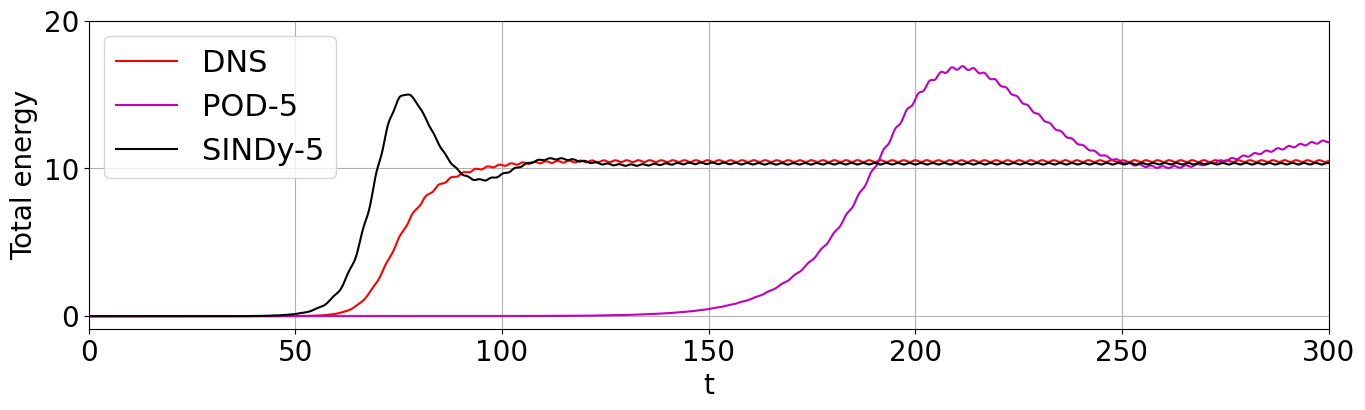

In [13]:
# define energies of the DNS, and both the 5D and 9D models 
# for POD-Galerkin and the trapping SINDy models
E = np.sum(a ** 2, axis=1)
E_galerkin5 = np.sum(a_galerkin5 ** 2, axis=1)
E_sindy5 = np.sum(x_test_pred ** 2, axis=1)

# plot the energies
plt.figure(figsize=(16, 4))
plt.plot(t, E, 'r', label='DNS')
plt.plot(t, E_galerkin5, 'm', label='POD-5')
plt.plot(t, E_sindy5, 'k', label=r'SINDy-5')

# do some formatting and save
plt.legend(fontsize=22, loc=2)
plt.grid()
plt.xlim([0, 300])
ax = plt.gca()
ax.set_yticks([0, 10, 20])
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.ylabel('Total energy', fontsize=20)
plt.xlabel('t', fontsize=20)
plt.show()

### Key result: the 5D SINDy model is globally stable and improves the prediction of the transient timing compared with the POD-Galerkin model.